# Applying S&P 500 on October 9, 2007 to a Kalman Filter


<pre>



    My understanding of the math behind the Kalman filter is similar to least squared regression that would
    predict a future value but its based on the recent trend.

    A useful application, for example, is radar tracking, where you dont expect sudden shifts in the trend.
    
    Its helpful to google the advantages and disadvantages of using the Kalman filter.
    
</pre>


In [14]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl 
import random

In [7]:
import warnings
warnings.filterwarnings('ignore')  # to avoid dataframe warnings when running Monte Carlo simulation 

<br>

Here we define function for the Kalman filter, a Monte Carlo Simulator, and supporting data frame and visualization functions

<br>

In [17]:
# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],    # The value for At. It is a random walk so is set to 1.0
                  observation_matrices = [1],   # The value for Ht.
                  initial_state_mean = 400,       # Any initial value. It will converge to the true state value.
                  initial_state_covariance = 1, # Sigma value for the Qt in Equation (1) the Gaussian distribution
                  observation_covariance=1,     # Sigma value for the Rt in Equation (2) the Gaussian distribution
                  transition_covariance=.01)    # A small turbulence in the random walk parameter 1.0

    
def addNewTradingDay(simPrice,kalmanPrice,tradingDay,data):
    data.loc[tradingDay]=[0,0,0,0,simPrice,0,kalmanPrice]    
    return(data)
    
def monteCarlo(data):
    
    returns = data['Adj Close'].pct_change()
    daily_vol = returns.std()
    
    T = len(data)
    count = 0
    price_list = []
    last_price = data['Adj Close'][-1]

    price = last_price * (1 + np.random.normal(0, daily_vol))
    price_list.append(price)

    for y in range(T):
        price = price_list[count]* (1 + np.random.normal(0, daily_vol))
        price_list.append(price)
        count += 1

    NUM_SIMULATIONS =  1000
    df = pd.DataFrame()
    last_price_list = []
    for x in range(NUM_SIMULATIONS):
        count = 0
        price_list = []
        price = last_price * (1 + np.random.normal(0, daily_vol))
        price_list.append(price)

        for y in range(T):
            price = price_list[count]* (1 + np.random.normal(0, daily_vol))
            price_list.append(price)
            count += 1

        df[x] = price_list
        last_price_list.append(price_list[-1])

  
    return(round(np.mean(last_price_list),2), np.percentile(last_price_list,5), 
           np.percentile(last_price_list,95), last_price_list)

<br>

Download the S&P since 2001

<br>

In [9]:
import yfinance as yf

seven_years_df = yf.download("^GSPC", start="2001-1-01", end="2007-10-10")

[*********************100%***********************]  1 of 1 completed


<br>

Apply the filter.

<br>

In [11]:
state_means, state_covariances = kf.filter(seven_years_df['Adj Close'].values)
seven_years_df['KF_mean'] = np.array(state_means)

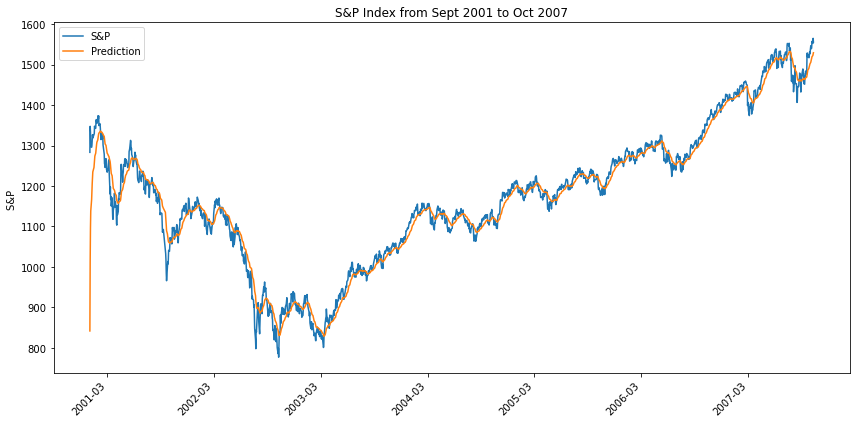

In [28]:
months_3_Loc = mpl.dates.MonthLocator(interval=12)
xFmt = mpl.dates.DateFormatter('%Y-%m')

fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, tight_layout=True, figsize=(12, 6))

ax.plot_date(seven_years_df.index,seven_years_df['Adj Close'].values , '-' , label='S&P')
ax.plot_date(seven_years_df.index,seven_years_df['KF_mean'].values , '-', label='Prediction' )

ax.xaxis.set_major_locator(months_3_Loc) 
ax.xaxis.set_minor_formatter(xFmt)  
ax.set(ylabel="S&P ", xlabel='')
ax.set_title('S&P Index from Sept 2001 to Oct 2007')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')  # have to force the rotation here

plt.xticks(rotation = 45, ha='right') 

plt.legend(loc='upper left')
plt.show()

<br>

Using Peter's simultation, derive an expected valuation using a random walk.

<br>

In [18]:
sim_price,sim_price_bottomQ,sim_price_topQ, last_price_list=monteCarlo(seven_years_df)

print("Expected price: ", sim_price)
print("Quantile (5%): ",sim_price_bottomQ)
print("Quantile (95%): ",sim_price_topQ)

Expected price:  1555.97
Quantile (5%):  690.8484410191415
Quantile (95%):  2869.925240967807


<br>

Call filter_update to get the prediction for the next day.

<br>

In [27]:
next_mean,next_covariance=kf.filter_update(state_means[-1],state_covariances[-1],sim_price)
seven_years_df=addNewTradingDay(sim_price,next_mean[0],"2007-10-10",seven_years_df)
print("The prediction for October 10th is ", int(seven_years_df.loc['2007-10-10','KF_mean']))

The prediction for October 10th is  1529


<br>

If you keep running the filter the predictions will continue upward which obviously is not what happened in late 2007.

<br>